In [1]:
from copy import deepcopy
from functools import partial
import os
import pickle

import folktables
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection, sklearn.linear_model
from tqdm.contrib.concurrent import process_map

import postprocess
import utils

split_ratio_for_test = 0.3
split_ratio_for_postprocessing = 0.1  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 43)

# This seed controls the randomness during pre-training (fixed)
seed_for_pretraining = 33

max_workers = 32

data_dir = "data/acsincome"

## Load ACSIncome dataset from `folktables`

In [2]:
if not os.path.exists(f"{data_dir}/raw_dataset.pkl"):
  os.makedirs(data_dir, exist_ok=True)
  data_source = folktables.ACSDataSource(survey_year='2018',
                                         horizon='1-Year',
                                         survey='person')
  raw_dataset = data_source.get_data(download=True)
  with open(f"{data_dir}/raw_dataset.pkl", "wb") as f:
    pickle.dump(raw_dataset, f)
else:
  with open(f"{data_dir}/raw_dataset.pkl", "rb") as f:
    raw_dataset = pickle.load(f)

In [3]:
ACSIncome_categories = {
    "COW": {
        1.0: ("Employee of a private for-profit company or"
              "business, or of an individual, for wages,"
              "salary, or commissions"),
        2.0: ("Employee of a private not-for-profit, tax-exempt,"
              "or charitable organization"),
        3.0:
            "Local government employee (city, county, etc.)",
        4.0:
            "State government employee",
        5.0:
            "Federal government employee",
        6.0: ("Self-employed in own not incorporated business,"
              "professional practice, or farm"),
        7.0: ("Self-employed in own incorporated business,"
              "professional practice or farm"),
        8.0:
            "Working without pay in family business or farm",
        9.0:
            "Unemployed and last worked 5 years ago or earlier or never worked",
    },
    "SCHL": {
        1.0: "No schooling completed",
        2.0: "Nursery school, preschool",
        3.0: "Kindergarten",
        4.0: "Grade 1",
        5.0: "Grade 2",
        6.0: "Grade 3",
        7.0: "Grade 4",
        8.0: "Grade 5",
        9.0: "Grade 6",
        10.0: "Grade 7",
        11.0: "Grade 8",
        12.0: "Grade 9",
        13.0: "Grade 10",
        14.0: "Grade 11",
        15.0: "12th grade - no diploma",
        16.0: "Regular high school diploma",
        17.0: "GED or alternative credential",
        18.0: "Some college, but less than 1 year",
        19.0: "1 or more years of college credit, no degree",
        20.0: "Associate's degree",
        21.0: "Bachelor's degree",
        22.0: "Master's degree",
        23.0: "Professional degree beyond a bachelor's degree",
        24.0: "Doctorate degree",
    },
    "MAR": {
        1.0: "Married",
        2.0: "Widowed",
        3.0: "Divorced",
        4.0: "Separated",
        5.0: "Never married or under 15 years old",
    },
    "SEX": {
        1.0: "Male",
        2.0: "Female"
    },
    "RAC1P": {
        1.0: "White alone",
        2.0: "Black or African American alone",
        3.0: "American Indian alone",
        4.0: "Alaska Native alone",
        5.0: ("American Indian and Alaska Native tribes specified;"
              "or American Indian or Alaska Native,"
              "not specified and no other"),
        6.0: "Asian alone",
        7.0: "Native Hawaiian and Other Pacific Islander alone",
        8.0: "Some Other Race alone",
        9.0: "Two or More Races",
    },
}


def get_group_labels_and_print_statistics(sensitive_attribute, n_classes):
  target = 'PINCP'
  features = [
      'AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX',
      'RAC1P'
  ]
  df = folktables.adult_filter(raw_dataset)

  if n_classes == 2:
    label_names = ["<=50K", ">50K"]
    target_transform = lambda x: (x > 50000).astype(int)

  else:
    # Compute empirical CDF of PINCP
    x = np.sort(df[target])
    y = np.arange(len(x)) / float(len(x))

    # Partition into bins containing roughly the same number of samples
    partitions = np.array([
        x[np.argmax(y >= q)] for q in np.arange(1 / n_classes, 1, 1 / n_classes)
    ] + [np.inf])

    label_names = [f'[0, {partitions[0]})'] + [
        f'[{partitions[i]}, {partitions[i+1]})'
        for i in range(len(partitions) - 1)
    ]
    target_transform = lambda x: np.argmax(
        np.array(x)[:, None] < partitions[None, :], axis=1)

  categories = deepcopy(ACSIncome_categories)
  if sensitive_attribute == 'RAC1P':
    # Combine RAC1P categories 3, 4, 5, and 6, 7, and 8, 9 into new categories
    # 10, 11, and 12 respectively, due to small sample size in some groups.
    # This is also consistent with the UCI Adult dataset.
    categories['RAC1P'][10.0] = "American Indian or Alaska Native alone"
    categories['RAC1P'][
        11.0] = "Asian, Native Hawaiian or Other Pacific Islander alone"
    categories['RAC1P'][12.0] = "Other"
    df['RAC1P'] = df['RAC1P'].replace([3.0, 4.0, 5.0], 10.0)
    df['RAC1P'] = df['RAC1P'].replace([6.0, 7.0], 11.0)
    df['RAC1P'] = df['RAC1P'].replace([8.0, 9.0], 12.0)

  data, labels, groups = folktables.BasicProblem(
      features=features,
      target=target,
      target_transform=target_transform,
      group=sensitive_attribute,
      postprocess=lambda x: np.nan_to_num(x, -1),
  ).df_to_pandas(df, categories=categories, dummies=True)

  labels = labels.values.squeeze()
  groups = groups.values.squeeze()

  group_names, groups = np.unique(groups, return_inverse=True)
  group_names = [categories[sensitive_attribute][n] for n in group_names]
  n_groups = len(group_names)

  df = pd.DataFrame(np.stack(
      [np.array(group_names)[groups],
       np.array(label_names)[labels]], axis=1),
                    columns=["Group", "Target"])
  df_grouped = df.groupby(["Target", "Group"]).size().unstack()
  counts = df_grouped.sum(axis=0)
  print("Dataset statistics:")
  display(df_grouped / counts)
  display(pd.DataFrame(counts, columns=["Count"]).T)

  print("Perfect results if dataset equals population:")
  display(
      pd.DataFrame([{
          "alpha":
              np.inf,
          "accuracy":
              1.0,
          "delta_dp":
              utils.delta_dp(labels, groups),
          "delta_dp_rms":
              utils.delta_dp(
                  labels,
                  groups,
                  ord=2,
              ) / np.sqrt(n_classes)
      }, {
          "alpha":
              0.0,
          "accuracy":
              1 - postprocess.PostProcessorDP().fit(
                  scores=np.concatenate(
                      [np.eye(n_classes) for _ in range(n_groups)], axis=0),
                  groups=np.repeat(np.arange(n_groups), n_classes),
                  sample_weight=np.nan_to_num(
                      (df_grouped.to_numpy() / counts.to_numpy())).T.flatten(),
              ).score_,
          "delta_dp":
              0.0,
          "delta_dp_rms":
              0.0
      }]).groupby('alpha').agg('mean').sort_index(ascending=False))

  return data, labels, label_names, groups, group_names

## Gender as sensitive attribute and income >50k as target

In [4]:
(data, labels, label_names, groups,
 group_names) = get_group_labels_and_print_statistics(
     sensitive_attribute='SEX', n_classes=2)

data = data.values
n_classes = len(label_names)
n_groups = len(group_names)

(data_, train_data_pre, labels_, train_labels_pre, groups_,
 train_groups_pre) = sklearn.model_selection.train_test_split(
     data,
     labels,
     groups,
     test_size=(1 - split_ratio_for_test) *
     (1 - split_ratio_for_postprocessing),
     random_state=seed_for_pretraining,
 )

n_samples = len(data)
n_test = int(n_samples * split_ratio_for_test)
n_post = n_samples - len(train_data_pre) - n_test

Dataset statistics:


Group,Female,Male
Target,,
<=50K,0.710121,0.558329
>50K,0.289879,0.441671


Group,Female,Male
Count,797765,866735


Perfect results if dataset equals population:


,accuracy,delta_dp,delta_dp_rms
alpha,,,
inf,1.000000,0.151793,0.151793
0.0,0.924104,0.000000,0.000000


In [5]:
# Train a logistic regression model on the pre-training data
predictor = sklearn.linear_model.LogisticRegression(
    random_state=seed_for_pretraining, max_iter=10000)
predictor.fit(train_data_pre, train_labels_pre)
probas_ = predictor.predict_proba(data_)

  0%|          | 0/150 [00:00<?, ?it/s]

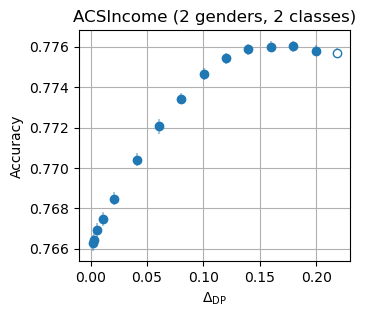

accuracy            delta_dp          
           mean       std      mean       std
alpha                                        
inf    0.775686  0.000249  0.218747  0.000541
0.200  0.775801  0.000271  0.199530  0.002659
0.180  0.776023  0.000258  0.179672  0.002714
0.160  0.776016  0.000283  0.159661  0.002780
0.140  0.775882  0.000276  0.139771  0.002775
0.120  0.775426  0.000286  0.119967  0.002704
0.100  0.774653  0.000311  0.100091  0.002901
0.080  0.773431  0.000281  0.080487  0.003129
0.060  0.772068  0.000360  0.060566  0.003274
0.040  0.770413  0.000318  0.040842  0.003146
0.020  0.768480  0.000334  0.020828  0.002891
0.010  0.767485  0.000339  0.010774  0.002915
0.005  0.766935  0.000364  0.005644  0.002799
0.001  0.766431  0.000379  0.002734  0.001452
0.000  0.766293  0.000392  0.002327  0.001587

In [6]:
alphas = [
    np.inf, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
    0.005, 0.001, 0.0
]

return_vals = process_map(
    partial(
        utils.postprocess,
        postprocessor_factory=postprocess.PostProcessorDP,
        evaluate_fn=partial(utils.evaluate,
                            n_groups=n_groups,
                            n_classes=n_classes,
                            metrics=['delta_dp']),
        probas=probas_,
        labels=labels_,
        groups=groups_,
        n_post=n_post,
        n_test=n_test,
    ),
    [(alpha, seed) for alpha in alphas for seed in seeds],
    max_workers=max_workers,
)
results = [{
    'alpha': alpha,
    **result
} for alpha, _, result, _ in return_vals if result is not None]

(fig, ax), df = utils.plot_results(results, 'delta_dp')
ax.set_xlabel("$\\Delta_{\\mathrm{DP}}$")
ax.set_title("ACSIncome (2 genders, 2 classes)")
plt.show()
display(df)

## Race as sensitive attribute and 5 buckets of income as target

In [7]:
(data, labels, label_names, groups,
 group_names) = get_group_labels_and_print_statistics(
     sensitive_attribute='RAC1P', n_classes=5)

data = data.values
n_classes = len(label_names)
n_groups = len(group_names)

(data_, train_data_pre, labels_, train_labels_pre, groups_,
 train_groups_pre) = sklearn.model_selection.train_test_split(
     data,
     labels,
     groups,
     test_size=(1 - split_ratio_for_test) *
     (1 - split_ratio_for_postprocessing),
     random_state=seed_for_pretraining,
 )

n_samples = len(data)
n_test = int(n_samples * split_ratio_for_test)
n_post = n_samples - len(train_data_pre) - n_test

Dataset statistics:


Group,American Indian or Alaska Native alone,"Asian, Native Hawaiian or Other Pacific Islander alone",Black or African American alone,Other,White alone
Target,,,,,
"[0, 15000.0)",0.260657,0.188757,0.246298,0.254518,0.179713
"[15000.0, 30000.0)",0.255286,0.164627,0.242449,0.263917,0.178926
"[30000.0, 48600.0)",0.245150,0.173386,0.236425,0.229817,0.218850
"[48600.0, 78030.0)",0.154125,0.178597,0.164854,0.149180,0.210315
"[78030.0, inf)",0.084782,0.294632,0.109973,0.102568,0.212197


Group,American Indian or Alaska Native alone,"Asian, Native Hawaiian or Other Pacific Islander alone",Black or African American alone,Other,White alone
Count,14897,99212,147573,104692,1298126


Perfect results if dataset equals population:


,accuracy,delta_dp,delta_dp_rms
alpha,,,
inf,1.000000,0.20985,0.112405
0.0,0.917661,0.00000,0.000000


In [8]:
# Train a logistic regression model on the pre-training data
predictor = sklearn.linear_model.LogisticRegression(
    random_state=seed_for_pretraining, max_iter=10000)
predictor.fit(train_data_pre, train_labels_pre)
probas_ = predictor.predict_proba(data_)

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/190 [00:00<?, ?it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


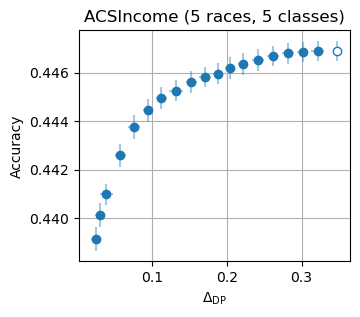

accuracy            delta_dp           delta_dp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.446908  0.000409  0.347433  0.001408     0.181980  0.000742
0.32   0.446906  0.000415  0.321424  0.008679     0.169543  0.003506
0.30   0.446860  0.000420  0.301550  0.007674     0.161477  0.002886
0.28   0.446812  0.000434  0.281939  0.007492     0.154130  0.002784
0.26   0.446703  0.000425  0.261596  0.007972     0.146984  0.002737
0.24   0.446541  0.000451  0.242145  0.007777     0.140773  0.002260
0.22   0.446357  0.000443  0.221803  0.007095     0.135188  0.001891
0.20   0.446199  0.000437  0.204573  0.006886     0.130577  0.001909
0.18   0.445962  0.000432  0.188334  0.006262     0.125348  0.002299
0.16   0.445832  0.000431  0.171118  0.007628     0.120030  0.001862
0.14   0.445615  0.000443  0.152781  0.007771     0.115090  0.002378
0.12   0.445270  0.000436  0.132738  0.009261     0.098376  0.003437
0.10   0.444965  0.000444  0.112576  0.007725     0.082932  0.002529
0.08   0.444455  0.000477  0.094629  0.005957     0.067551  0.002327
0.06   0.443769  0.000483  0.075726  0.008063     0.054825  0.002059
0.04   0.442599  0.000486  0.057833  0.007596     0.039181  0.003609
0.02   0.440993  0.000442  0.038946  0.008527     0.023886  0.004111
0.01   0.440126  0.000493  0.030333  0.006674     0.018678  0.003536
0.00   0.439161  0.000497  0.025923  0.006668     0.015950  0.003220

In [9]:
alphas = [
    np.inf, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1,
    0.08, 0.06, 0.04, 0.02, 0.01, 0.0
]

return_vals = process_map(
    partial(
        utils.postprocess,
        postprocessor_factory=postprocess.PostProcessorDP,
        evaluate_fn=partial(utils.evaluate,
                            n_groups=n_groups,
                            n_classes=n_classes,
                            metrics=['delta_dp', 'delta_dp_rms']),
        probas=probas_,
        labels=labels_,
        groups=groups_,
        n_post=n_post,
        n_test=n_test,
    ),
    [(alpha, seed) for alpha in alphas for seed in seeds],
    max_workers=max_workers,
)
results = [{
    'alpha': alpha,
    **result
} for alpha, _, result, _ in return_vals if result is not None]

(fig, ax), df = utils.plot_results(results, 'delta_dp')
ax.set_xlabel("$\\Delta_{\\mathrm{DP}}$")
ax.set_title("ACSIncome (5 races, 5 classes)")
plt.show()
display(df)